In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
from xgboost import XGBRegressor

=== XGBoost ===
Migliori parametri trovati: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
R^2 (Test) = 0.9743
MAE (Test) = 3414.6713


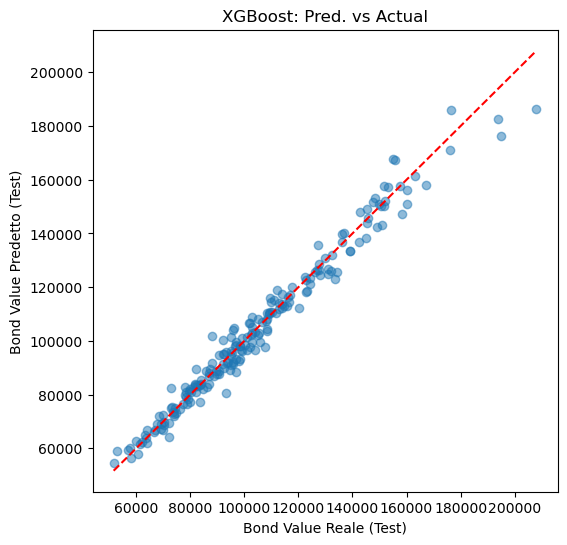


Esempio prime 5 righe con predicted_bond_value (XGBoost):
  credit_rating  debt_to_equity  energy_capacity         region  esg_rating  \
0            BB        0.925015        49.981000         Europe   20.775856   
1            AA        2.404028        29.555073  North America   90.184009   
2           BBB        2.008619         9.684890  North America   94.957444   
3           AAA        2.789894        20.601847         Europe   78.535606   
4           CCC        0.448415        32.440513         Europe    4.152142   

   predicted_bond_value  
0         163383.593750  
1         114618.593750  
2         136869.890625  
3          99733.109375  
4          96075.164062  


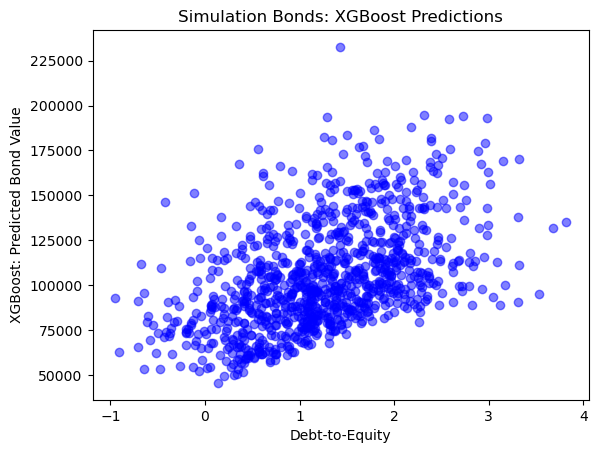

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Per XGBoost
from xgboost import XGBRegressor

# Preprocessing e valutazione
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ======================================
# 1) CARICAMENTO DATASET STORICO
# ======================================
df_hist = pd.read_csv("/Users/tommasomarrucci/Documents/GitHub/YALE/historical_bonds.csv")

# Calcolo del bond_value ignorando il Face Value (3 flussi di cassa)
r = 0.05
df_hist['bond_value'] = (
    df_hist['cash_flow_1'] / (1 + r) +
    df_hist['cash_flow_2'] / (1 + r)**2 +
    df_hist['cash_flow_3'] / (1 + r)**3
)

# ======================================
# 2) FEATURES E TARGET
# ======================================
features = ['credit_rating', 'debt_to_equity', 'energy_capacity', 'region', 'esg_rating']
X = df_hist[features]
y = df_hist['bond_value']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['debt_to_equity', 'energy_capacity', 'esg_rating']
categorical_features = ['credit_rating', 'region']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ======================================
# 3) MODELLO XGBOOST + GRID SEARCH
# ======================================
xgb_reg = XGBRegressor(random_state=42, 
                       objective='reg:squarederror')  
                       # objective='reg:squarederror' per MSE

param_grid = {
    'n_estimators': [100, 300],   # numero di alberi
    'max_depth': [3, 6],         # profondità
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0]
}

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search', GridSearchCV(
        xgb_reg, 
        param_grid, 
        scoring='r2', 
        cv=5, 
        n_jobs=-1
    ))
])

# 4) FIT
xgb_pipeline.fit(X_train, y_train)

# Estraiamo la grid search e il best_estimator
xgb_gs = xgb_pipeline.named_steps['grid_search']
best_xgb_model = xgb_gs.best_estimator_

print("=== XGBoost ===")
print("Migliori parametri trovati:", xgb_gs.best_params_)

# 5) VALUTAZIONE
y_pred_test = xgb_pipeline.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_test)
mae_xgb = mean_absolute_error(y_test, y_pred_test)

print(f"R^2 (Test) = {r2_xgb:.4f}")
print(f"MAE (Test) = {mae_xgb:.4f}")

# Plot Pred vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Bond Value Reale (Test)")
plt.ylabel("Bond Value Predetto (Test)")
plt.title("XGBoost: Pred. vs Actual")
plt.show()

# ======================================
# 6) APPLICAZIONE SU SIMULATION_BONDS
# ======================================
df_sim = pd.read_csv("/Users/tommasomarrucci/Documents/GitHub/YALE/simulation_bonds.csv")

df_sim['predicted_bond_value'] = xgb_pipeline.predict(df_sim[features])

print("\nEsempio prime 5 righe con predicted_bond_value (XGBoost):")
print(df_sim[['credit_rating','debt_to_equity','energy_capacity','region',
              'esg_rating','predicted_bond_value']].head())

# Salva se desideri
df_sim.to_csv("simulation_bonds_XGBOOST.csv", index=False)

# Plot di esempio su simulation
plt.figure()
plt.scatter(df_sim['debt_to_equity'], df_sim['predicted_bond_value'], alpha=0.5, color='blue')
plt.xlabel("Debt-to-Equity")
plt.ylabel("XGBoost: Predicted Bond Value")
plt.title("Simulation Bonds: XGBoost Predictions")
plt.show()